<a href="https://colab.research.google.com/github/Lalith2005reddy/HDR_Image_Segmentation/blob/main/Deeplab_test_last_for_day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
torch.cuda.empty_cache()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models.segmentation import deeplabv3_resnet101
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split

# Custom Dataset Class
class ExposureSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Read image and mask
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], 0)  # Read mask in grayscale

        # Resize images and masks
        image = cv2.resize(image, (480, 480))
        mask = cv2.resize(mask, (480, 480), interpolation=cv2.INTER_NEAREST)

        # Convert to PyTorch Tensors
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.from_numpy(image.transpose((2, 0, 1))).float() / 255.0

        mask = torch.from_numpy(mask).long()

        return image, mask

# Load Dataset
image_dir = '/content/drive/MyDrive/Dataset_phase_3/train/train_img'
mask_dir = '/content/drive/MyDrive/Dataset_phase_3/train/train_mask'

image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
mask_paths = [os.path.join(mask_dir, msk) for msk in os.listdir(mask_dir)]

# Filter images where all three classes are present
filtered_image_paths, filtered_mask_paths = [], []
for img_path, msk_path in zip(image_paths, mask_paths):
    mask = cv2.imread(msk_path, 0)
    unique_classes = np.unique(mask)
    if all(cls in unique_classes for cls in [0, 1, 2]):
        filtered_image_paths.append(img_path)
        filtered_mask_paths.append(msk_path)

# Split Dataset into Train and Test sets
train_images, val_images, train_masks, val_masks = train_test_split(filtered_image_paths, filtered_mask_paths, test_size=0.3, random_state=42)

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create DataLoader
train_dataset = ExposureSegmentationDataset(train_images, train_masks, transform=transform)
val_dataset = ExposureSegmentationDataset(val_images, val_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

# Load Pre-trained DeepLabV3 Model with ResNet-101 Backbone
model = deeplabv3_resnet101(pretrained=True)

# Modify the classifier for 3 classes (background, overexposed, underexposed)
model.classifier[4] = nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Changed to Adam optimizer

# Training the Model
num_epochs = 30  # Increased number of epochs
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward Pass
        outputs = model(images)['out']
        loss = criterion(outputs, masks)

        # Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    # Print Epoch Stats
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}")

    # Save the model checkpoint if it's the best so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_deeplabv3_model.pth')

print("Training Complete!")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LA

Epoch [1/30], Train Loss: 1.1200, Validation Loss: 1.0780
Epoch [2/30], Train Loss: 1.0007, Validation Loss: 1.0560
Epoch [3/30], Train Loss: 0.9123, Validation Loss: 1.0276
Epoch [4/30], Train Loss: 0.8123, Validation Loss: 1.0293
Epoch [5/30], Train Loss: 0.7584, Validation Loss: 1.0378
Epoch [6/30], Train Loss: 0.7030, Validation Loss: 1.3084
Epoch [7/30], Train Loss: 0.6248, Validation Loss: 1.1723
Epoch [8/30], Train Loss: 0.5295, Validation Loss: 1.0849


OutOfMemoryError: CUDA out of memory. Tried to allocate 226.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 221.06 MiB is free. Process 7187 has 14.53 GiB memory in use. Of the allocated memory 13.41 GiB is allocated by PyTorch, and 1.00 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [5]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

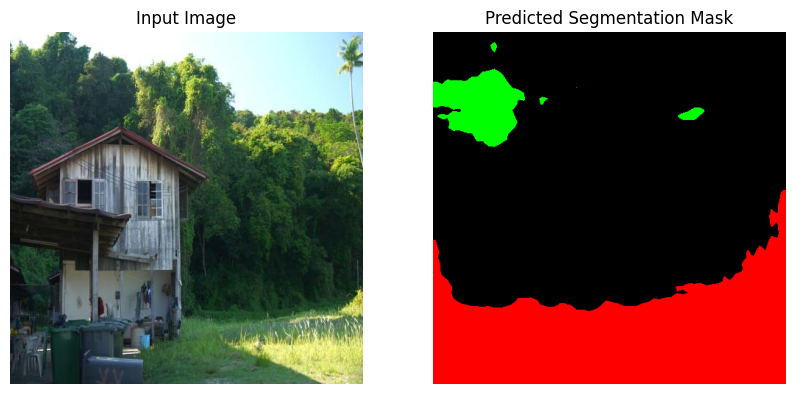

In [3]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Load the trained model
model = deeplabv3_resnet101(pretrained=False)
model.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))

# Load the state_dict while ignoring unnecessary keys
state_dict = torch.load('best_deeplabv3_model.pth', map_location=torch.device('cpu'), weights_only=True)

# Filter out the `aux_classifier` keys
filtered_state_dict = {k: v for k, v in state_dict.items() if 'aux_classifier' not in k}

# Load the filtered state_dict
model.load_state_dict(filtered_state_dict, strict=False)
model.eval()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define image transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

def predict_image(image_path, model, device):
    """
    Predicts the segmentation mask for a given input image using the trained model.
    """
    # Read and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (480, 480))
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Predict with the model
    with torch.no_grad():
        try:
            output = model(input_tensor)['out']  # Model output
            output = F.softmax(output, dim=1)  # Apply softmax to get class probabilities
            prediction = torch.argmax(output, dim=1).squeeze(0)  # Get the predicted class for each pixel
        except RuntimeError as e:
            print(f"Error during inference: {e}")
            return image, None

    return image, prediction.cpu().numpy()

def visualize_prediction(image, prediction):
    """
    Visualizes the input image and its predicted segmentation mask.
    """
    if prediction is None:
        print("Prediction is None. Skipping visualization.")
        return

    # Define color map for visualization
    colormap = np.array([[0, 0, 0],    # 0: Background (black)
                         [0, 255, 0],  # 1: Overexposed (green)
                         [255, 0, 0]]) # 2: Underexposed (red)

    # Create RGB mask
    rgb_mask = colormap[prediction]

    # Plot the input image and the predicted mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(rgb_mask)
    plt.title("Predicted Segmentation Mask")
    plt.axis('off')

    plt.show()

# Path to a test image
test_image_path = '/content/drive/MyDrive/Dataset_phase_3/valid/valid_img/img-44-_exposure1-5_gamma1-5_jpg.rf.87b99d68302781594080379811cd4536.jpg'  # Replace with the path to your test image

# Predict and visualize
image, prediction = predict_image(test_image_path, model, device)
visualize_prediction(image, prediction)
